<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/handwriting_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc , classification_report, confusion_matrix
from ipywidgets import interact, interactive, widgets, interact_manual, Dropdown

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import re

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("taeefnajib/handwriting-data-to-detect-alzheimers-disease")

print("Path to dataset files:", path)

100%|██████████| 332k/332k [00:00<00:00, 60.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1


In [ ]:
import os

# List the contents of the directory
directory_path = '/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1'
print(os.listdir(directory_path))

['data.csv']


In [ ]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/taeefnajib/handwriting-data-to-detect-alzheimers-disease/versions/1/data.csv')

print("Shape of the data:", data.shape)
data.head()

Shape of the data: (174, 452)


ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0  id_1       5160     0.000013    120.804174       86.853334   
1  id_2      51980     0.000016    115.318238       83.448681   
2  id_3       2600     0.000010    229.933997      172.761858   
3  id_4       2130     0.000010    369.403342      183.193104   
4  id_5       2310     0.000007    257.997131      111.275889   

   max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0               957              6601          0.361800            0.217459   
1              1694              6998          0.272513            0.144880   
2              2333              5802          0.387020            0.181342   
3              1756              8159          0.556879            0.164502   
4               987              4732          0.266077            0.145104   

   mean_gmrt1  ...  mean_jerk_in_air25  mean_jerk_on_paper25  \
0  103.828754  ...            0.141434              0.024471   
1   99.383459  ...            0.049663              0.018368   
2  201.347928  ...            0.178194              0.017174   
3  276.298223  ...            0.113905              0.019860   
4  184.636510  ...            0.121782              0.020872   

   mean_speed_in_air25  mean_speed_on_paper25  num_of_pendown25  paper_time25  \
0             5.596487               3.184589                71         40120   
1             1.665973               0.950249               129        126700   
2             4.000781               2.392521                74         45480   
3             4.206746               1.613522               123         67945   
4             3.319036               1.680629                92         37285   

   pressure_mean25  pressure_var25  total_time25  class  
0      1749.278166     296102.7676        144605      P  
1      1504.768272     278744.2850        298640      P  
2      1431.443492     144411.7055         79025      P  
3      1465.843329     230184.7154        181220      P  
4      1841.702561     158290.0255         72575      P  

[5 rows x 452 columns]

In [ ]:
data.info()

# Corrected dtypes to count numeric and categorical variables
numeric_vars = data.select_dtypes(include=['int64', 'float64']).columns
categorical_vars = data.select_dtypes(include=['object', 'category']).columns
print("===")
print(f"Number of numeric variables: {len(numeric_vars)}")
print(f"Number of categorical variables: {len(categorical_vars)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Columns: 452 entries, ID to class
dtypes: float64(300), int64(150), object(2)
memory usage: 614.6+ KB
===
Number of numeric variables: 450
Number of categorical variables: 2


In [ ]:
import plotly.express as px
fig = px.bar(data['class'].value_counts().reset_index(), x='class', y='count', title='Class Distribution')
fig.show()

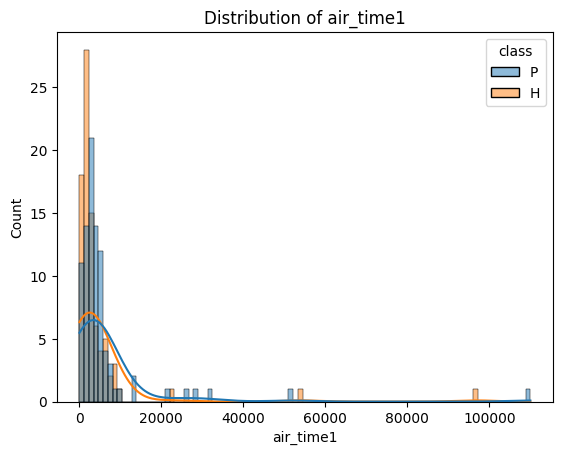

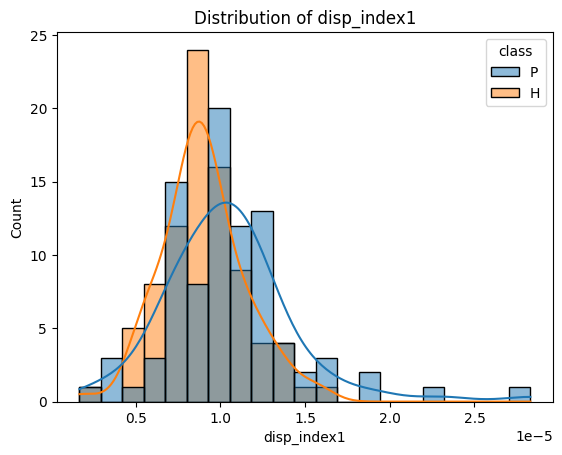

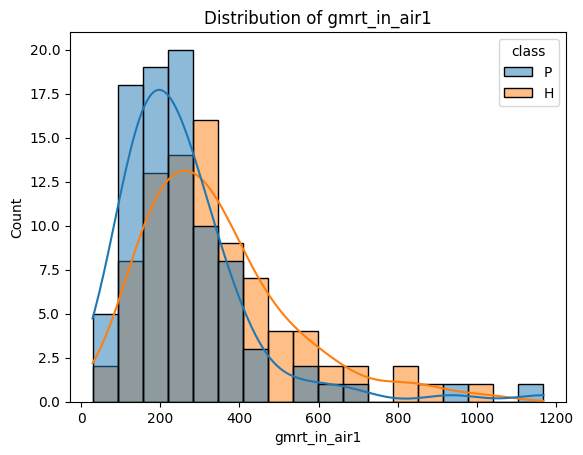

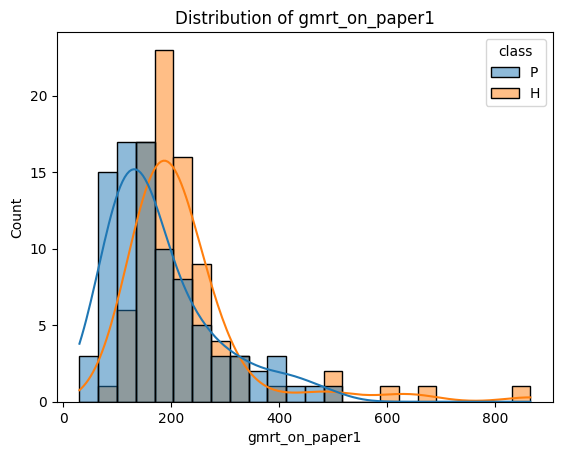

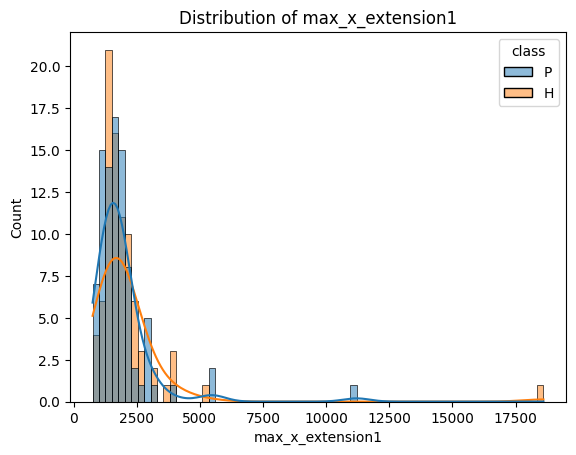

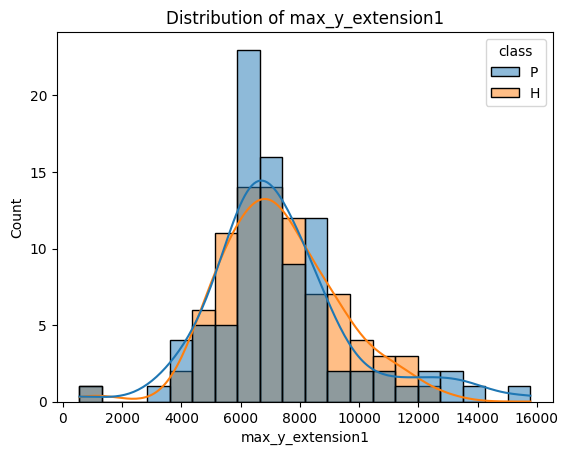

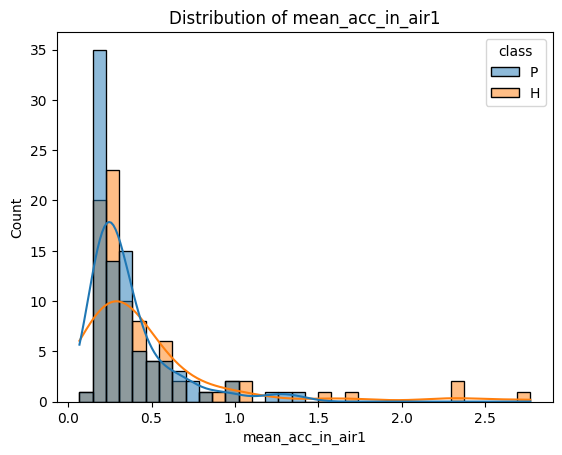

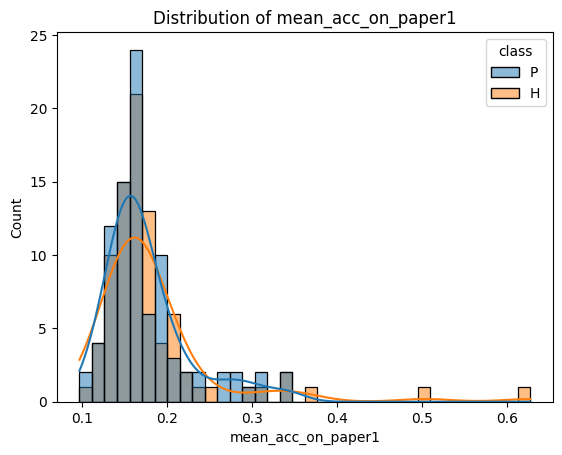

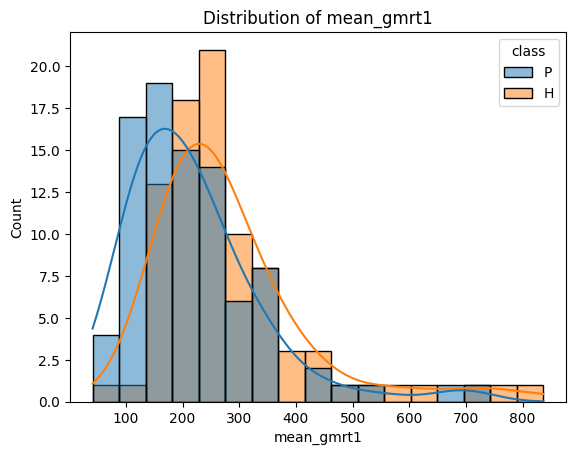

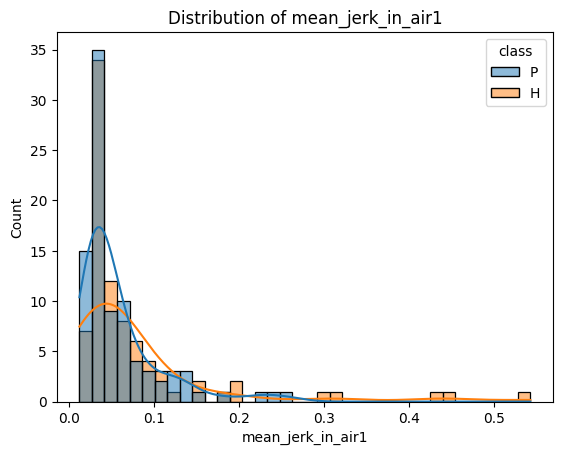

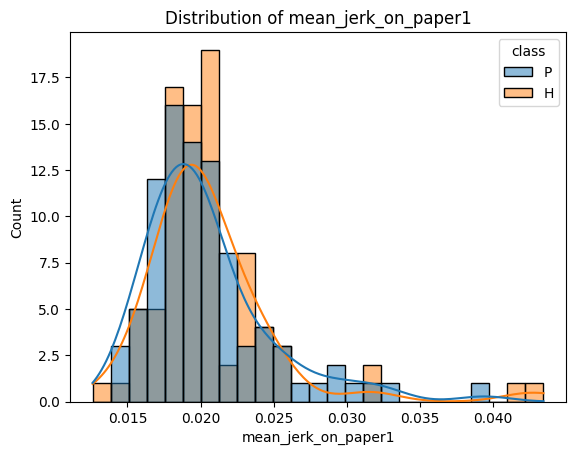

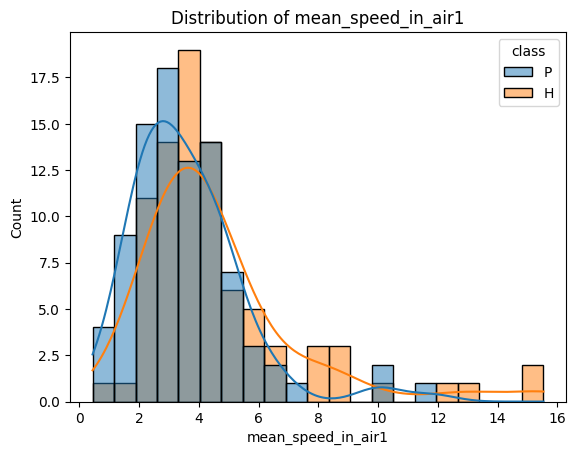

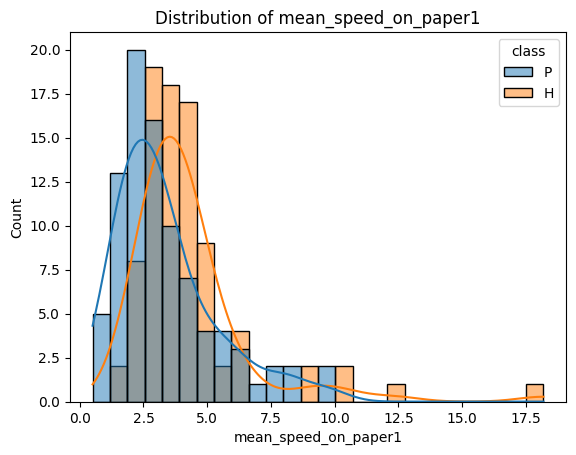

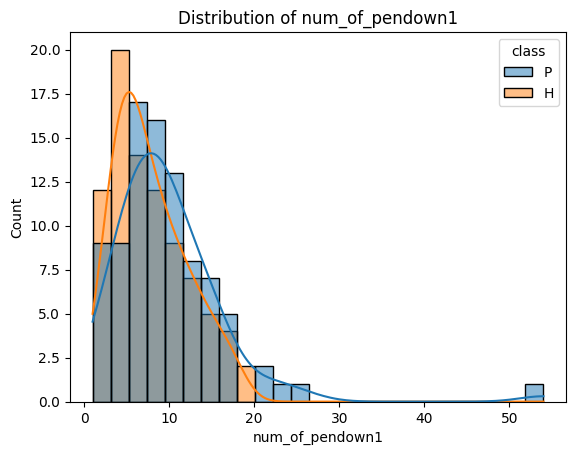

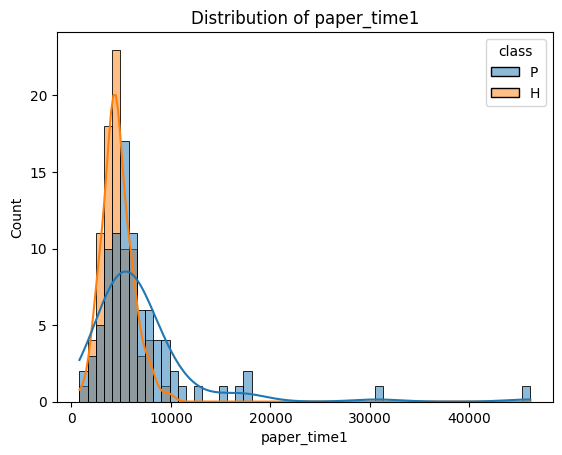

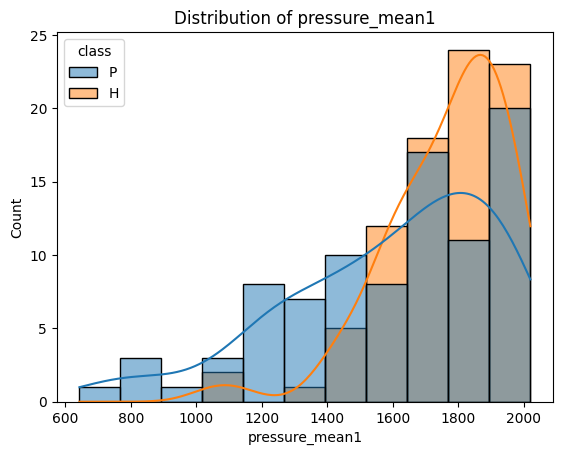

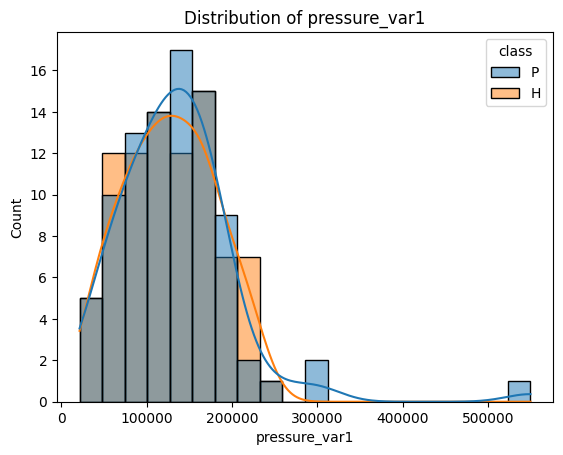

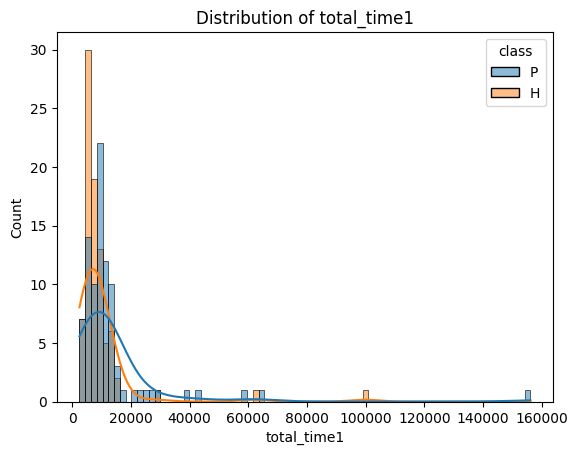

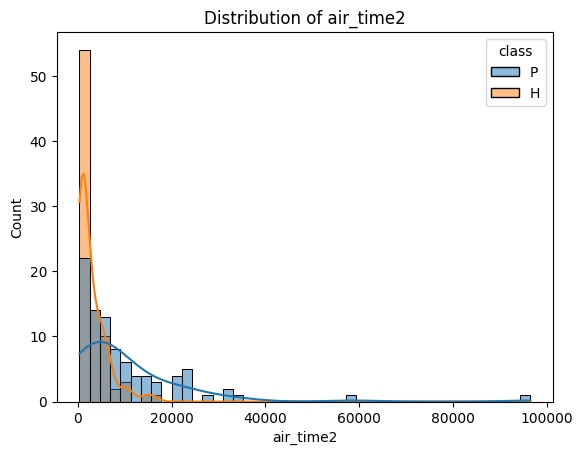

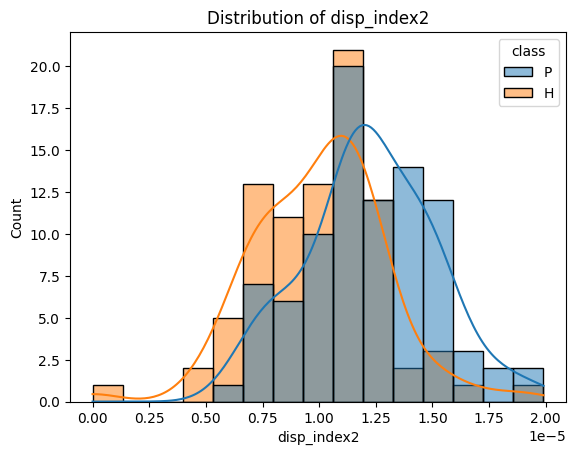

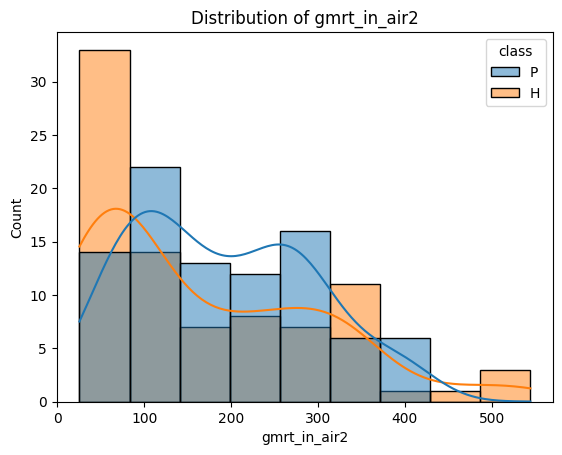

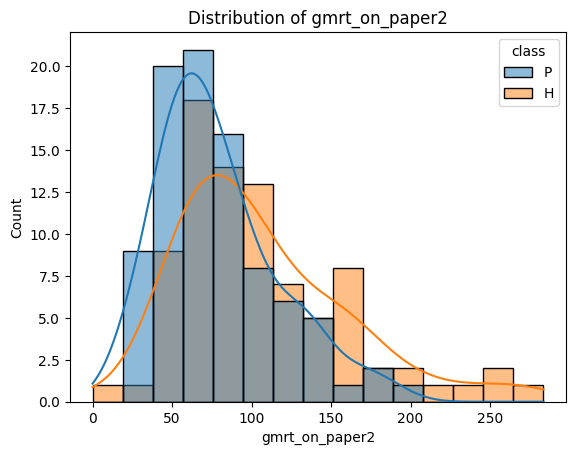

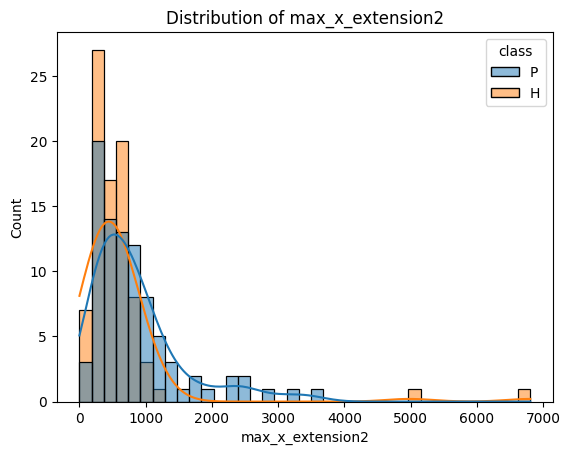

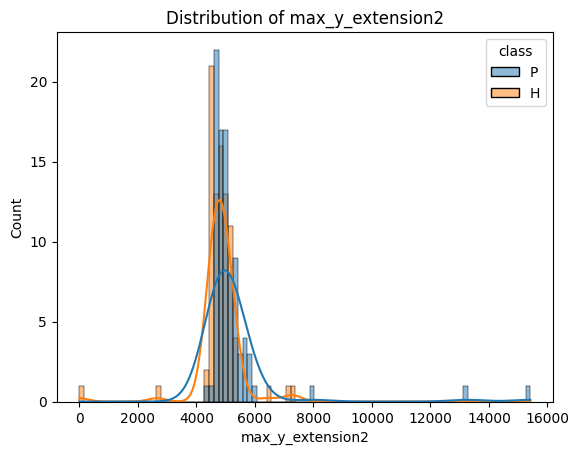

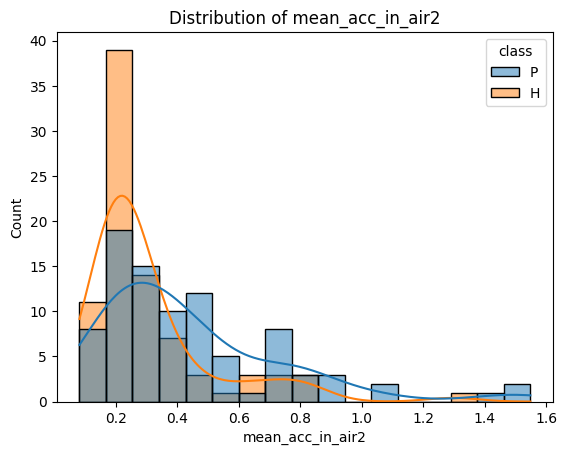

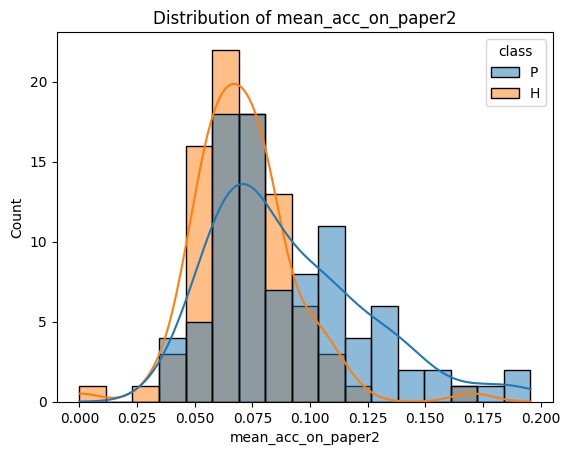

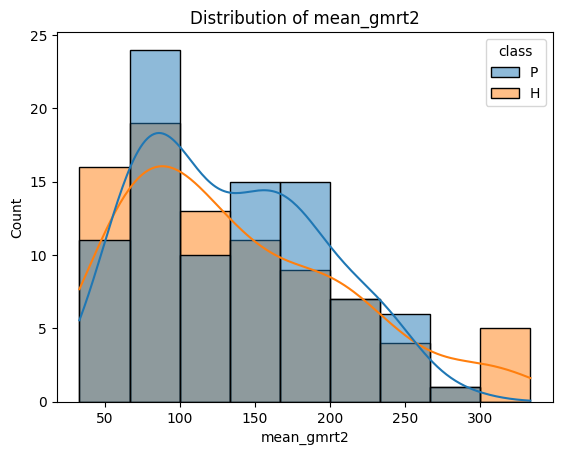

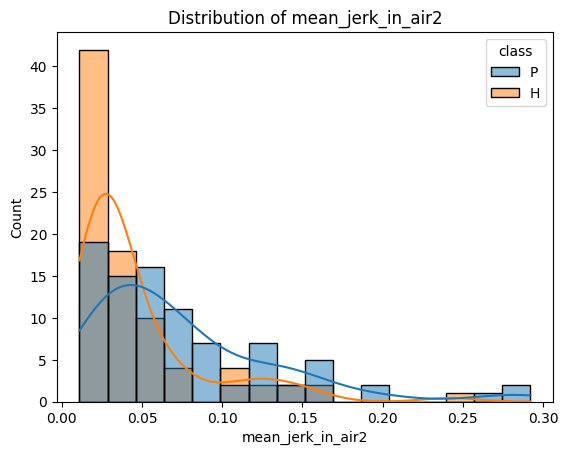

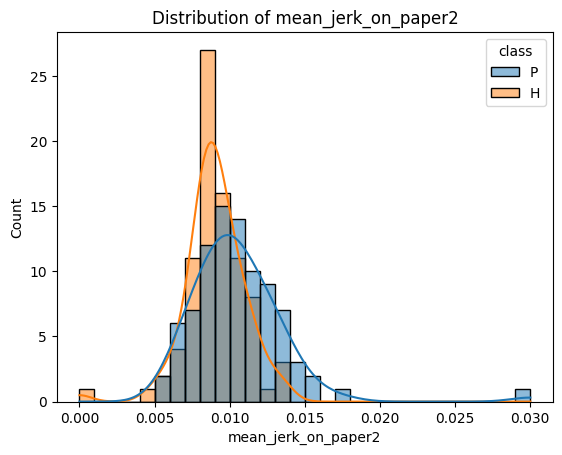

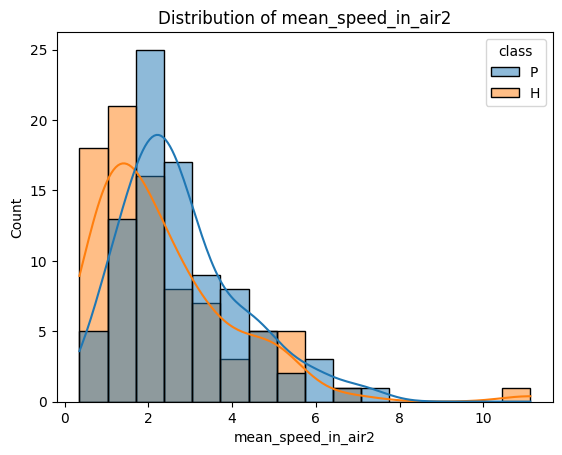

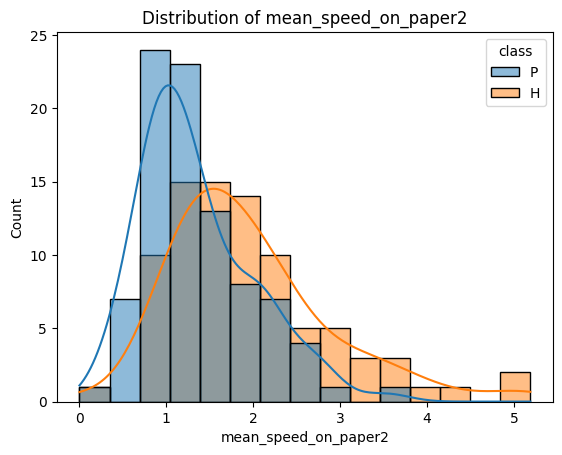

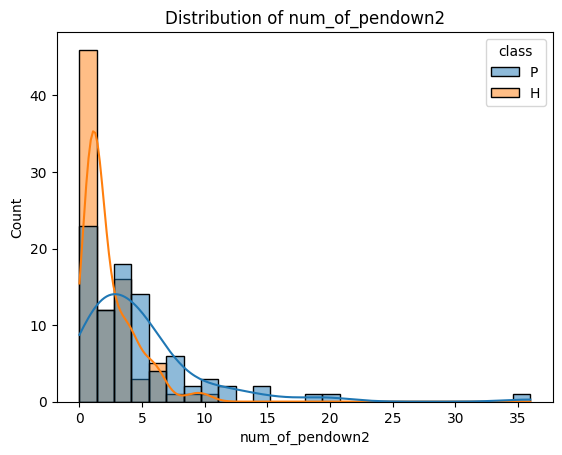

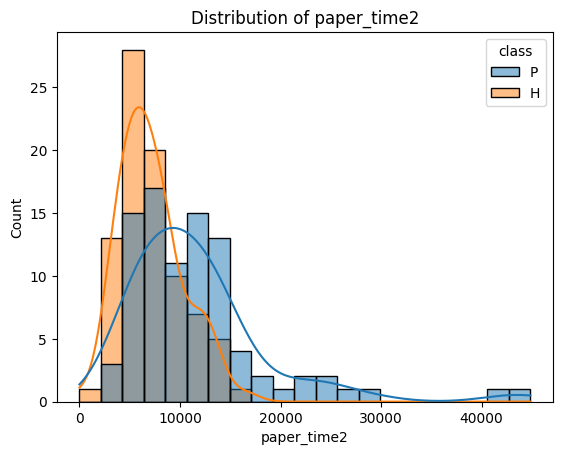

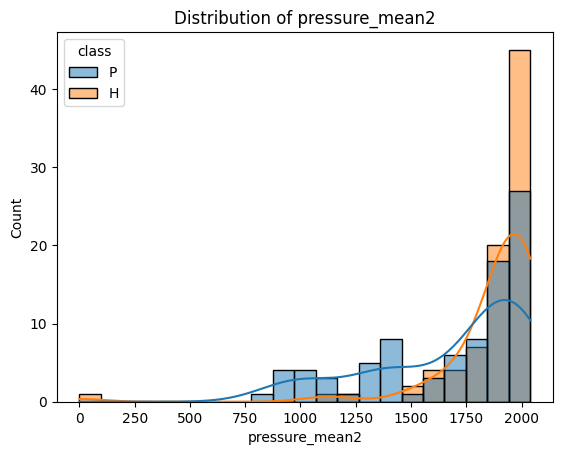

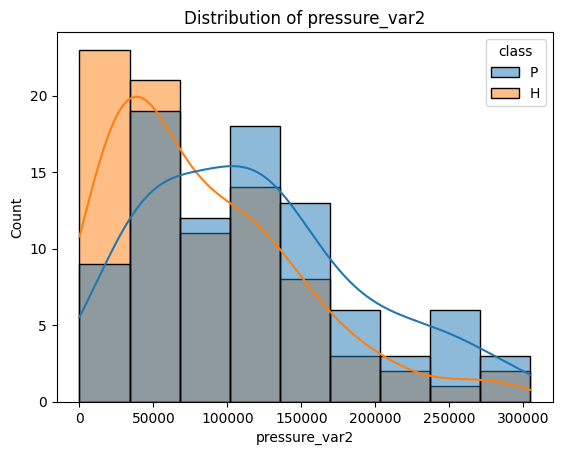

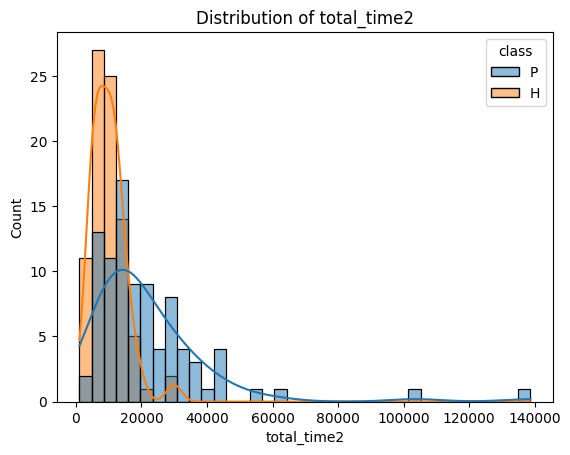

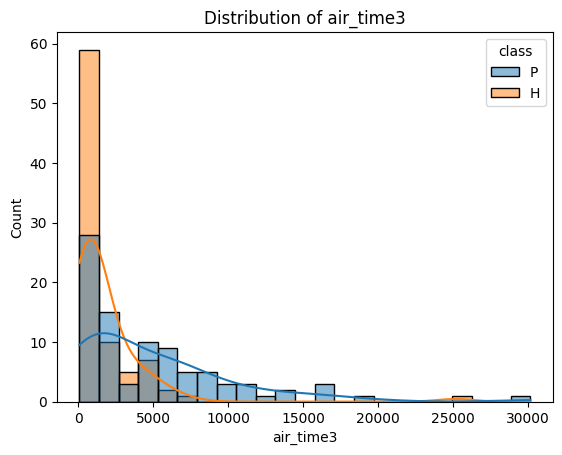

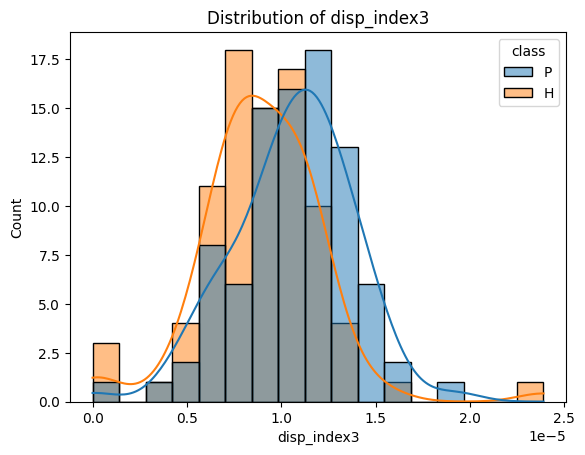

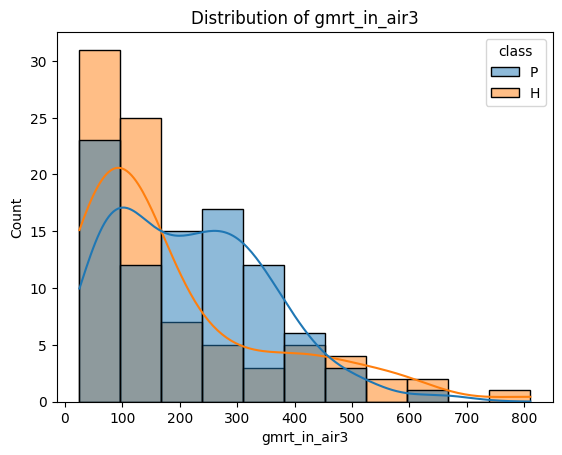

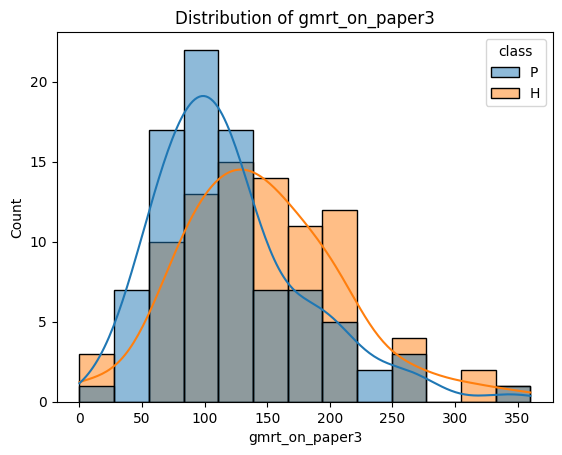

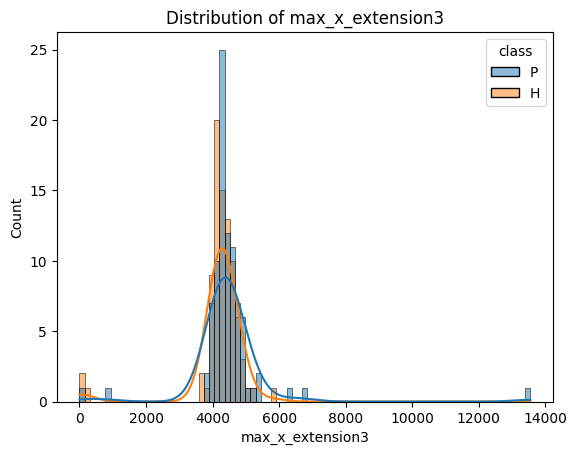

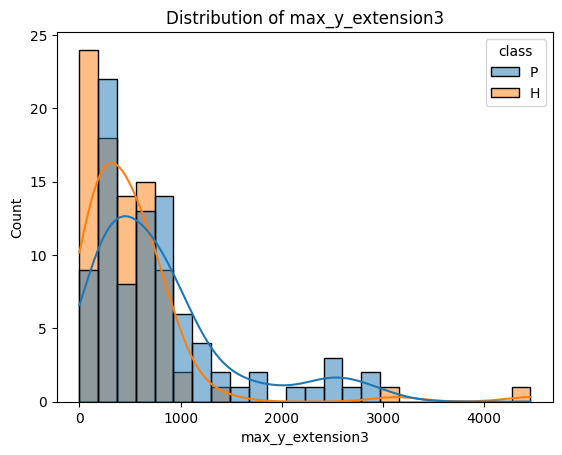

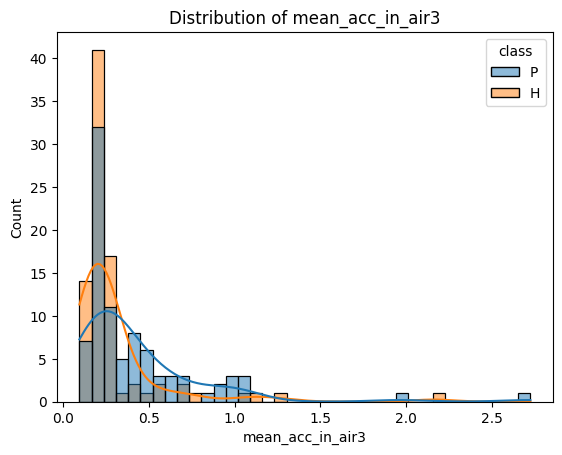

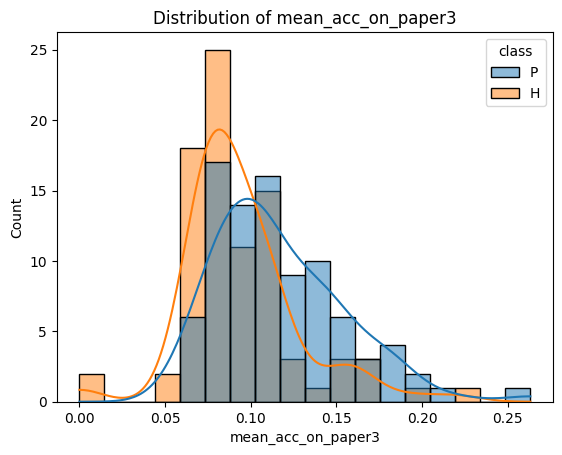

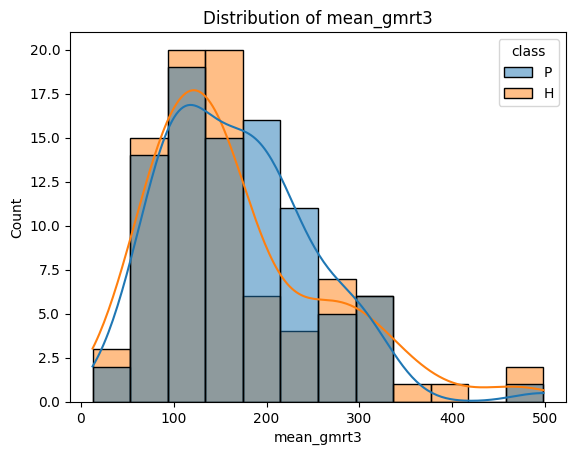

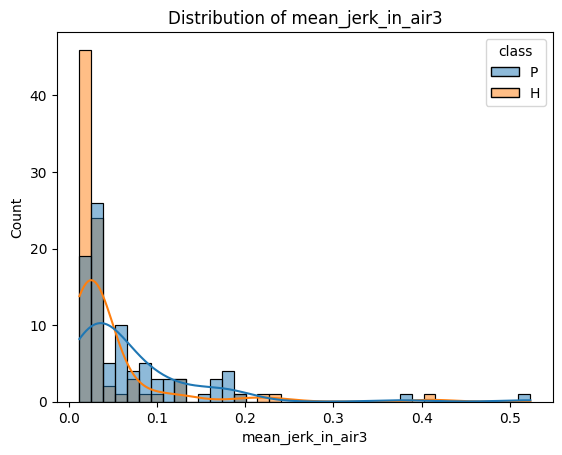

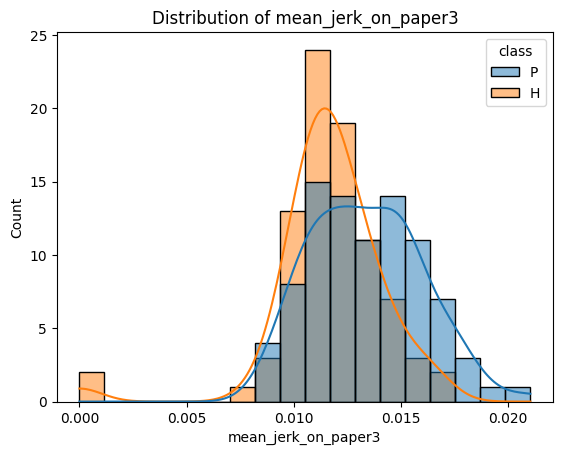

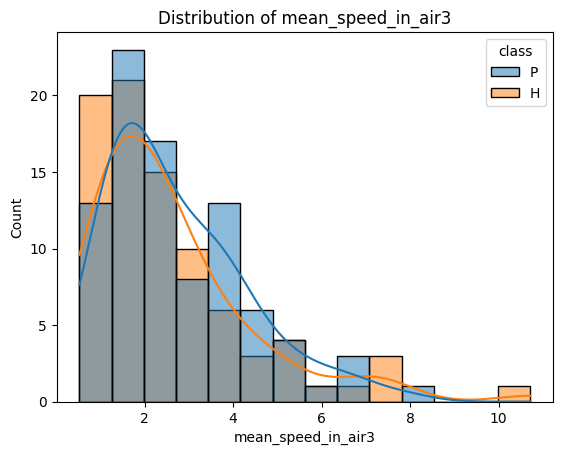

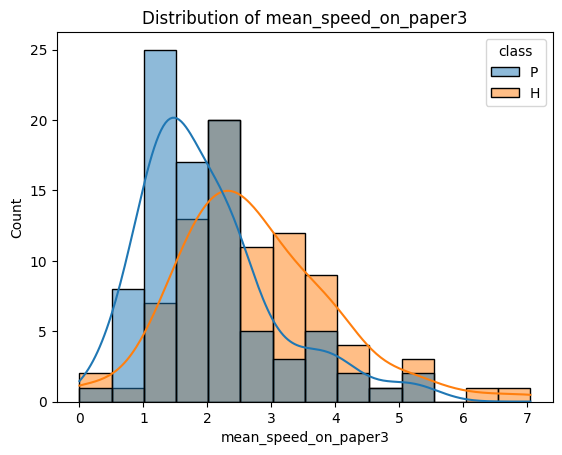

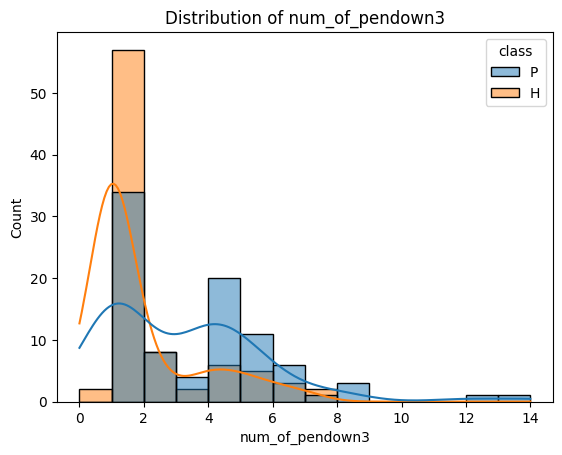

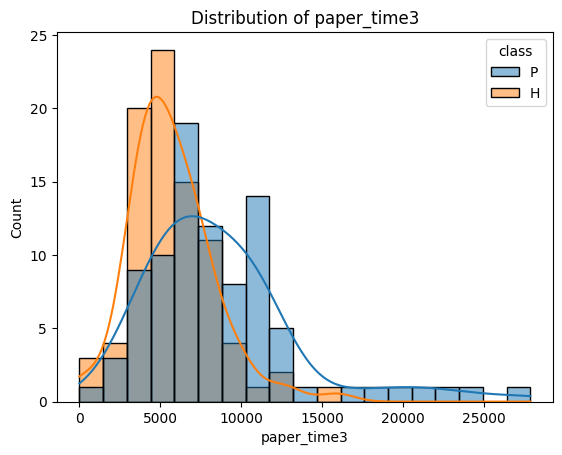

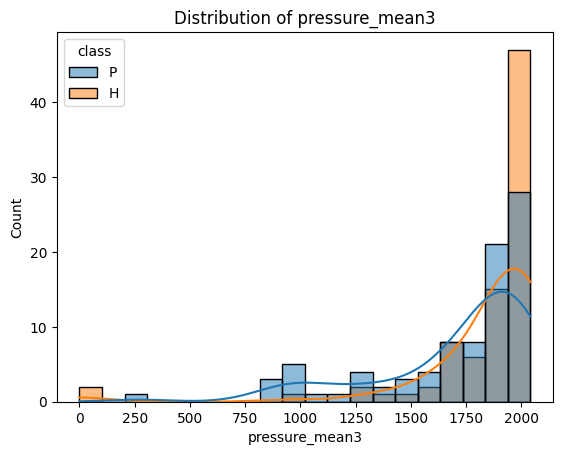

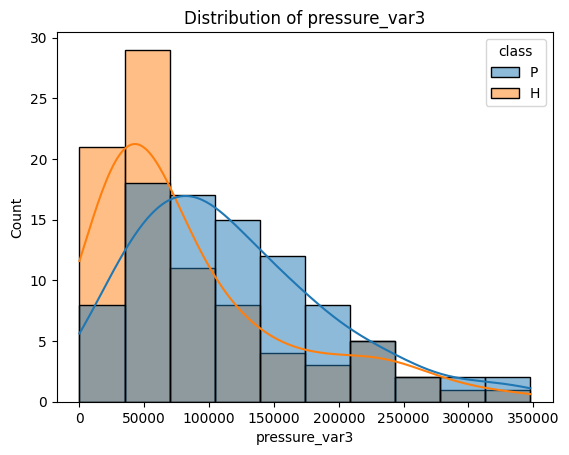

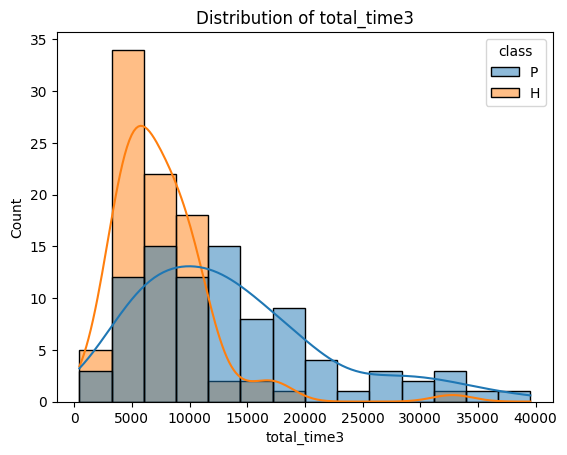

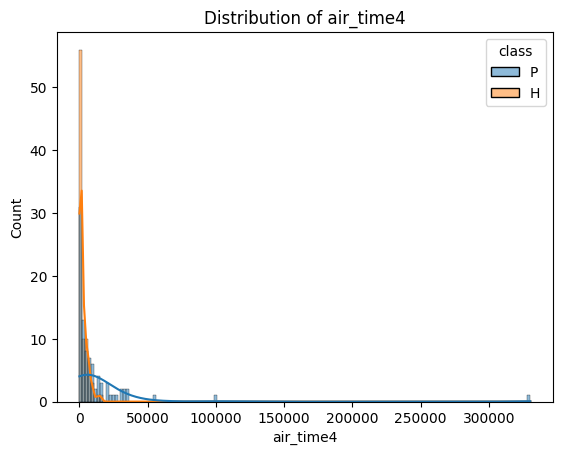

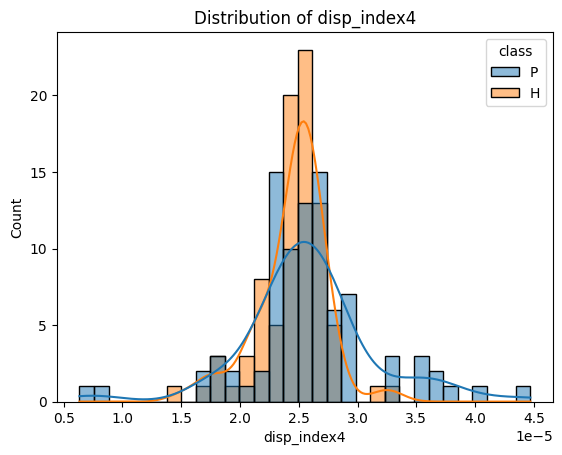

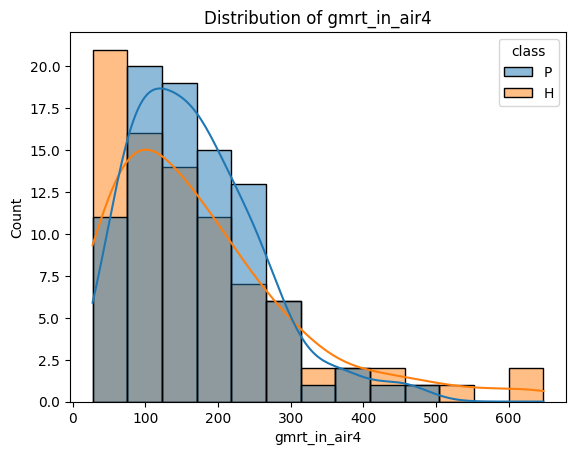

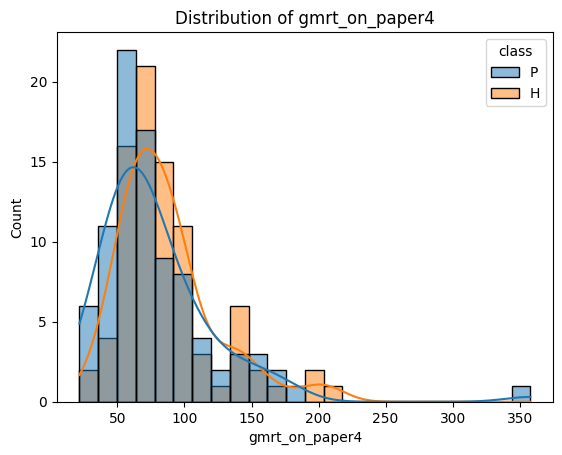

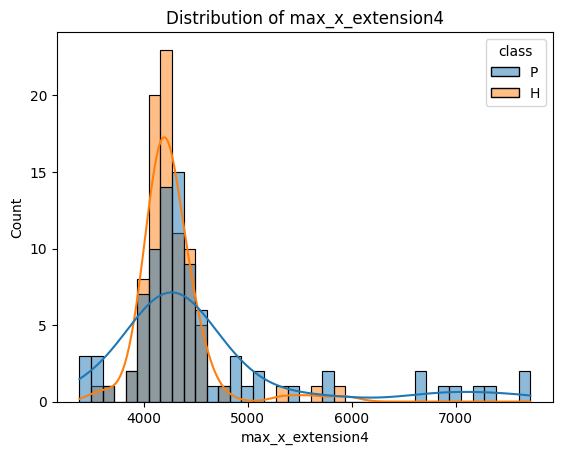

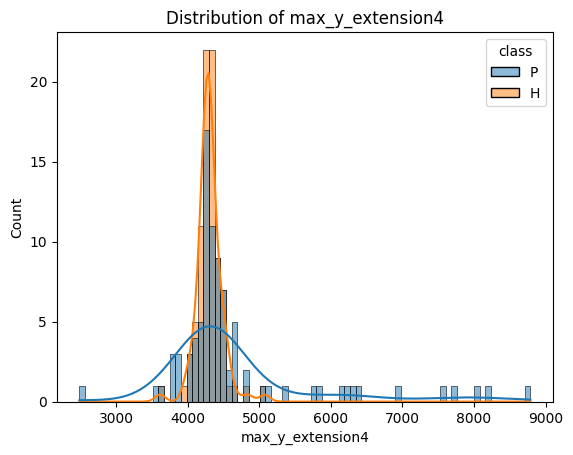

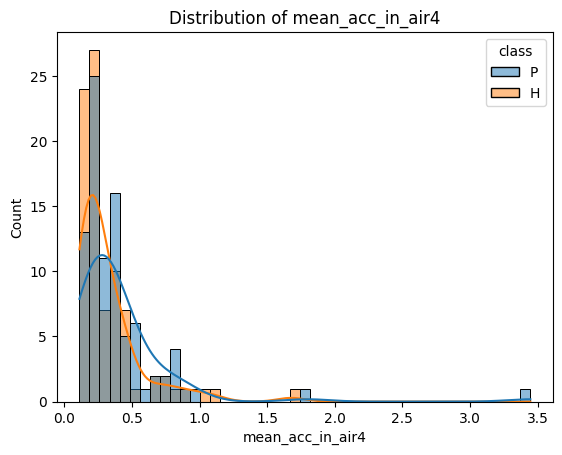

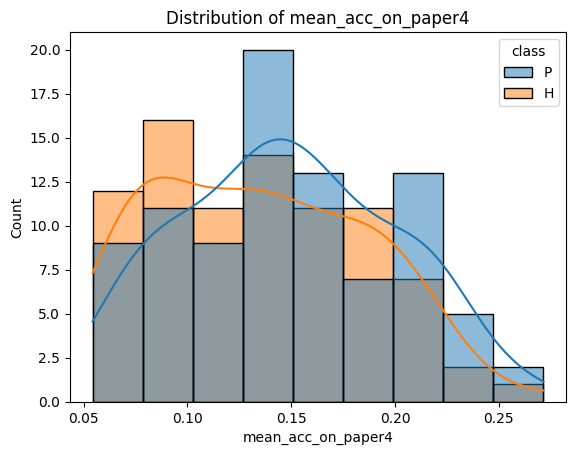

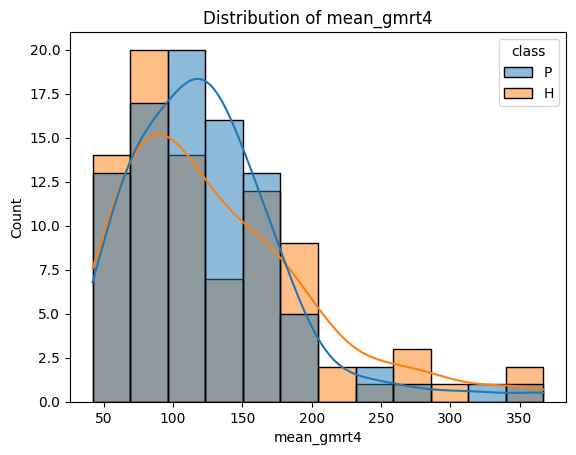

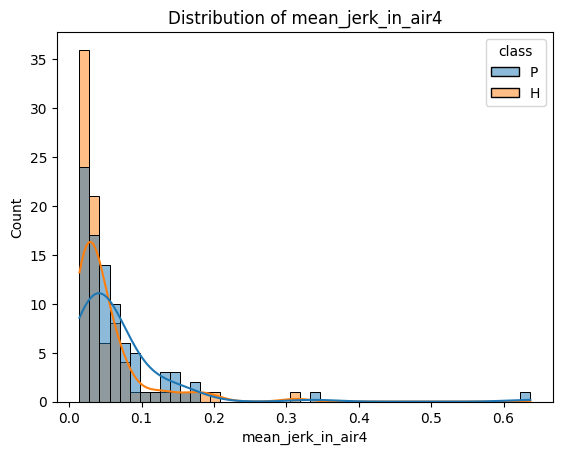

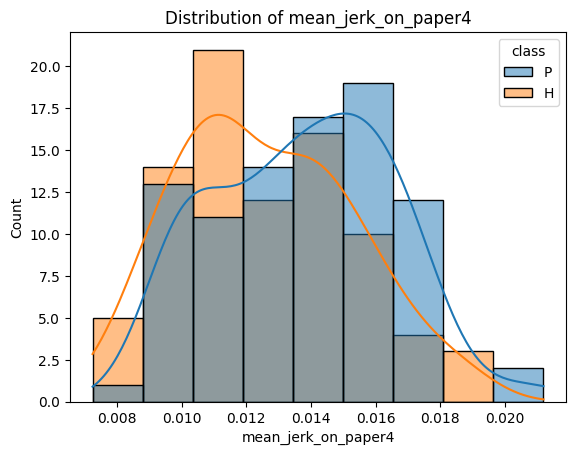

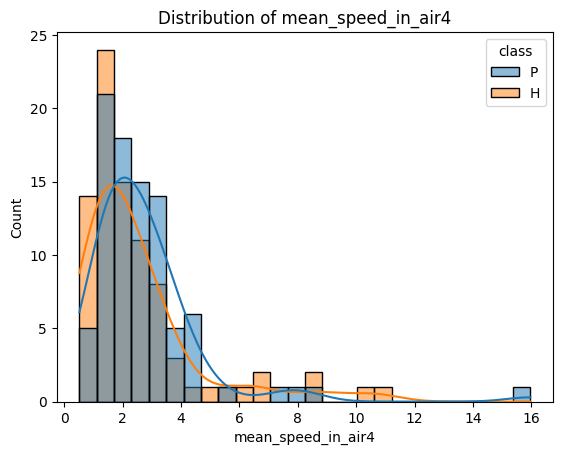

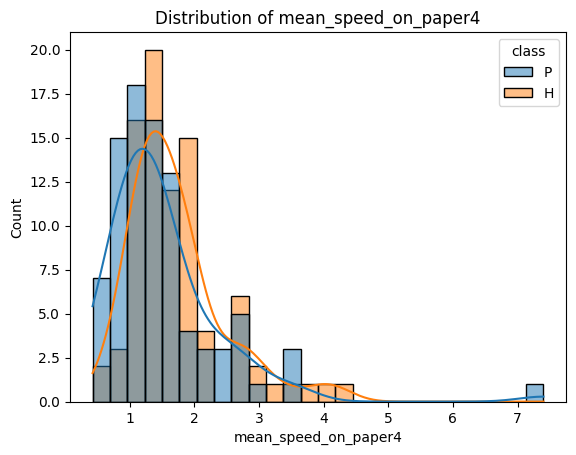

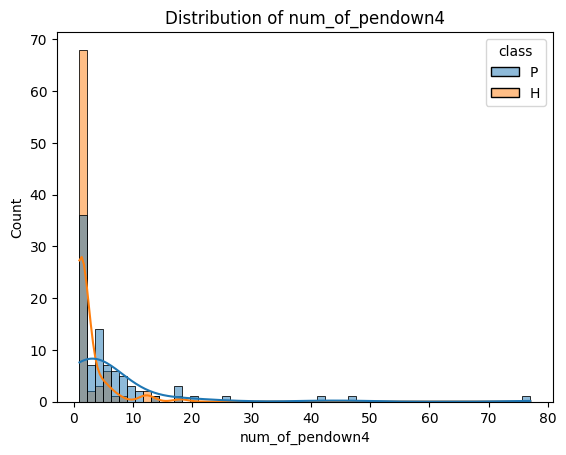

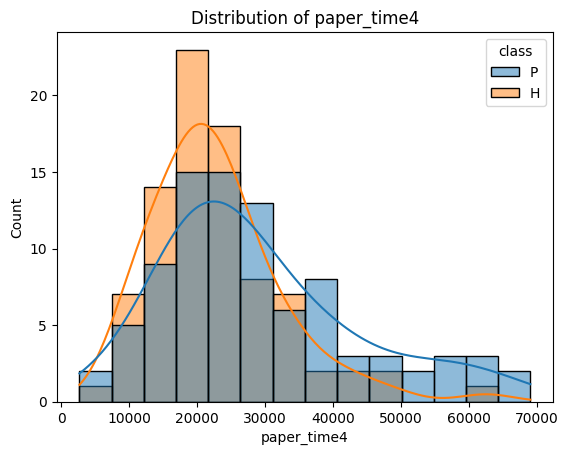

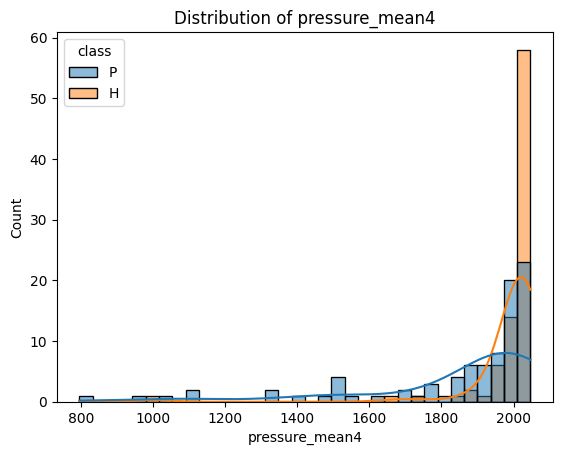

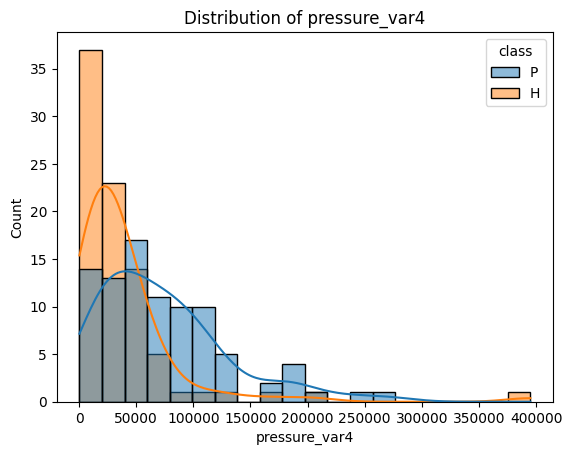

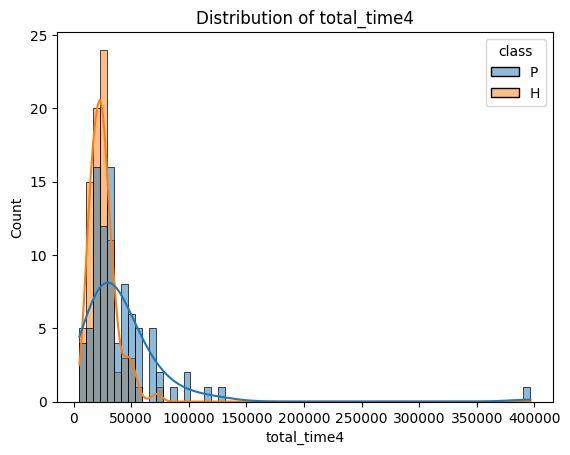

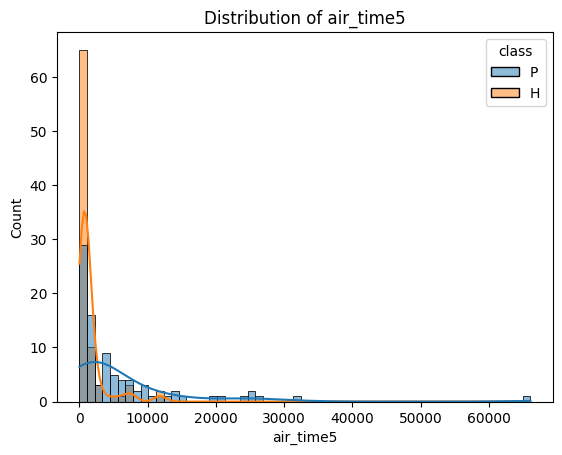

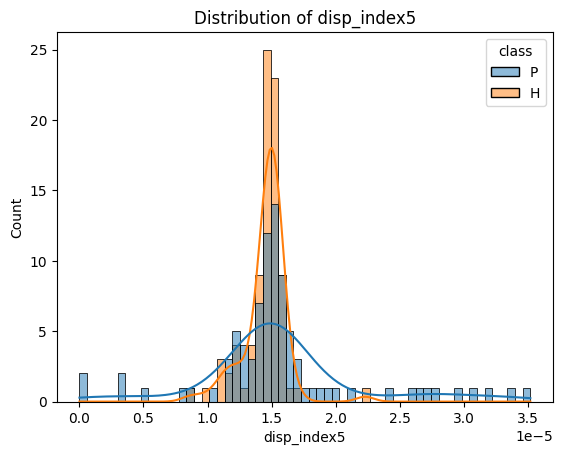

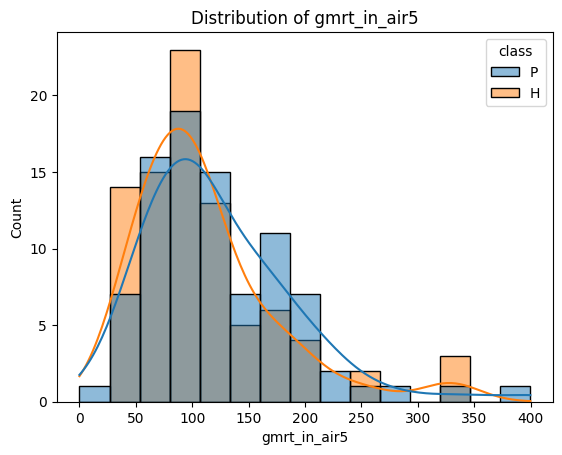

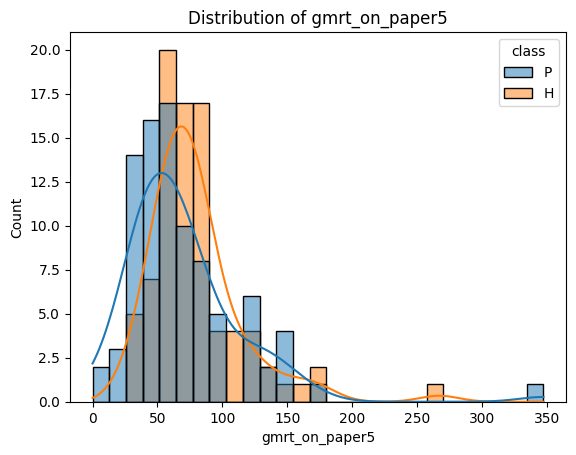

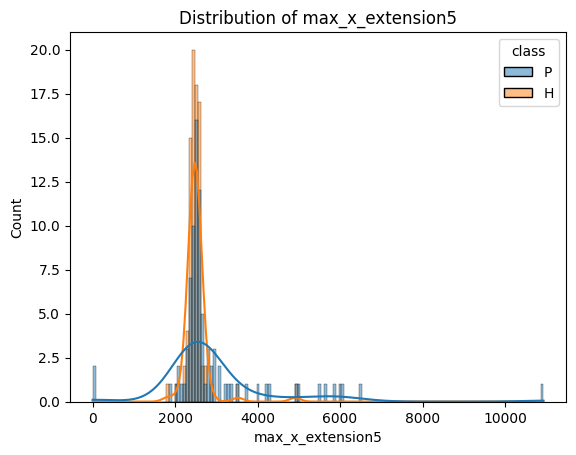

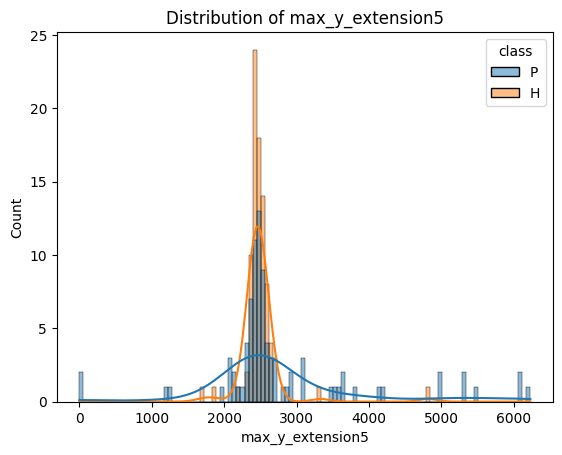

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in data.columns[1:-1]:  # Exclude ID and Class
    sns.histplot(data=data, x=col, hue='class', kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [ ]:
melted_df = pd.melt(data, id_vars=['class'], value_vars=data.columns[1:-1])
fig = px.box(melted_df, x='variable', y='value', color='class', title='Feature Boxplots by Class')
fig.show()

In [ ]:
data_encoded = data.copy()
data_encoded['class'] = data_encoded['class'].map({'H': 0, 'P': 1})
corr = data_encoded.corr(numeric_only=True) # Added numeric_only=True to handle non-numeric columns
fig = px.imshow(corr, text_auto=True, aspect='auto', title='Correlation Heatmap')
fig.show()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_encoded.iloc[:, 1:-1])
tsne_data = pd.DataFrame(tsne_results, columns=['Dim1', 'Dim2'])
tsne_data['class'] = data_encoded['class']
fig = px.scatter(tsne_data, x='Dim1', y='Dim2', color='class', title='t-SNE Visualization')
fig.show()

In [18]:
from sklearn.model_selection import train_test_split
X = data.iloc[:, 1:-1]
y = data['class'].map({'H': 0, 'P': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=10)  # Per task; loop over task groups
X_selected = selector.fit_transform(X_train, y_train)

In [20]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
fig = px.line(x=range(1, len(pca.explained_variance_ratio_)+1), y=np.cumsum(pca.explained_variance_ratio_), title='PCA Explained Variance')
fig.show()